# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [99]:
!pip install -r requirements.txt

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import mean_squared_error


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [101]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [102]:
# find out how many interactions
df.shape

(45993, 3)

In [103]:
# Show the distribution of how many articles a user interacts with in the dataset
# Group by email to count the number of interactions per user
user_interactions = df.groupby('email').size().reset_index(name='interaction_count')

# Descriptive statistics
print("Descriptive Statistics of User Interactions:")
print(user_interactions['interaction_count'].describe())

Descriptive Statistics of User Interactions:
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: interaction_count, dtype: float64


In [104]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_interactions['interaction_count'].median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = user_interactions['interaction_count'].max() # The maximum number of user-article interactions by any 1 user is 364.

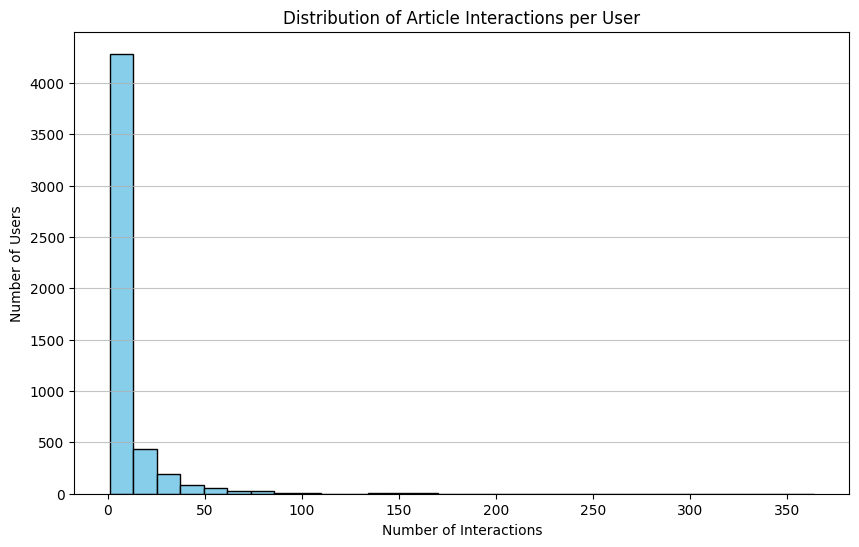

In [105]:
# Visualizing the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_interactions['interaction_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Article Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [106]:
df_content.shape

(1056, 5)

In [107]:
# Find and explore duplicate articles
print('Number of duplicates:', df_content.article_id.duplicated().sum())

Number of duplicates: 5


In [108]:
group_by_article_id = df_content.groupby('article_id').count() #group by article_id
group_by_article_id = group_by_article_id.reset_index()
duplicate_articles = group_by_article_id[group_by_article_id['doc_body'] > 1]
duplicate_articles

,article_id,doc_body,doc_description,doc_full_name,doc_status
50,50,2,2,2,2
221,221,2,2,2,2
232,232,2,2,2,2
398,398,2,2,2,2
577,577,2,2,2,2


In [109]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
assert df_content.duplicated().sum() == 0, 'Duplicate articles'
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

**a.** The number of unique articles that have an interaction with a user.

In [110]:
# The number of unique articles that have at least one interaction
df['article_id'].nunique()

714

In [111]:
# The number of unique articles on the IBM platform
df_content['article_id'].nunique()

1051

In [112]:
# The number of unique users
df['email'].nunique()

5148

In [113]:
# The number of user-article interactions
df.shape[0]

45993

In [114]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [115]:
# count viewed by article_id
df.article_id.value_counts().head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: count, dtype: int64

In [116]:
df.article_id.value_counts().iloc[0]

np.int64(937)

In [117]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

In [118]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded



In [119]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [120]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [121]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count the number of interactions per article
    top_articles_df = df['article_id'].value_counts().head(n)
    
    # Retrieve the titles for the top articles
    top_articles = df[df['article_id'].isin(top_articles_df.index)]['title'].drop_duplicates().tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids 
    
    '''
    # Get the most viewed article_ids
    top_article_ids = df['article_id'].value_counts().head(n).index.tolist()
    
    return top_article_ids


In [122]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [123]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [124]:
# convert article_id to object 
df['article_id'] = df['article_id'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   user_id     45993 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [125]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Pivot the data to create the user-item matrix
    user_item = df.pivot_table(
        index='user_id', 
        columns='article_id', 
        aggfunc='size',  # Count the interactions
        fill_value=0     # Fill missing values with 0
    )

    # Convert all non-zero values to 1 (binary representation of interaction)
    user_item = (user_item > 0).astype(int)
    
    return user_item


user_item = create_user_item_matrix(df)

In [126]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [127]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of users
    
    '''
    # Compute similarity of each user to the provided user (dot product)
    user_vector = user_item.loc[user_id]
    similarity_scores = user_item.dot(user_vector)
    
    # Sort by similarity score in descending order
    similarity_scores = similarity_scores.sort_values(ascending=False)
    
    # Create a list of user IDs, excluding the input user_id
    most_similar_users = similarity_scores.index[similarity_scores.index != user_id].tolist()
    
    return most_similar_users


In [128]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [129]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    
    Description:
    Retrieve the article titles corresponding to the provided list of article ids.
    '''
    # # convert the list of article_ids to a list of floats
    # article_ids = [float(x) for x in article_ids]
    # Filter the DataFrame to include rows with the specified article_ids, and extract unique titles
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of article_ids and article titles that the user has interacted with.
    '''
    # Find the article_ids that the user has interacted with (value 1 in the user-item matrix)
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    
    # Retrieve the article names corresponding to these article_ids
    article_names = get_article_names(article_ids)
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Generate a list of article recommendations for a given user based on their similarity 
    to other users. Articles that the user has not interacted with will be suggested.
    '''
    # Retrieve the list of similar users based on similarity (dot product)
    similar_users = find_similar_users(user_id)
    
    # Get the articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id)
    
    # Initialize an empty set to collect recommendations
    recs = set()
    
    # Loop through similar users to find articles they interacted with but the given user has not seen
    for similar_user in similar_users:
        article_ids, _ = get_user_articles(similar_user)
        recs.update(set(article_ids) - set(seen_article_ids))
        
        # Stop when enough recommendations have been gathered
        if len(recs) >= m:
            break
    
    # Convert the set of recommendations to a list and return only the top m items
    recs = list(recs)[:m]
    return recs


In [130]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark lab, part 3: machine learning',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'times world university ranking analysis',
 'machine learning and the science of choosing',
 'this week in data science (april 25, 2017)',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'using machine learning to predict parking difficulty',
 'airbnb data for analytics: mallorca reviews',
 'from spark ml model to online scoring with scala']

In [131]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [132]:
get_user_articles(20)[0]

['1320.0', '232.0', '844.0']

In [133]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [ ]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) user ID for which neighbors are to be found
    df - (pandas dataframe) contains article interactions by user
    user_item - (pandas dataframe) user-item matrix where rows are users, 
                columns are articles, and values are 1 for interaction and 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) sorted dataframe with:
                    - neighbor_id: user IDs of neighbors
                    - similarity: dot product similarity with the given user
                    - num_interactions: total articles viewed by the neighbor user
    
    Description:
    Computes similarity of every user to the provided user_id using dot product.
    Sorts by similarity first and then by number of interactions.
    '''
    # Compute dot product similarity of all users with the input user
    similarity = user_item.dot(user_item.loc[user_id])
    # count number of interactions by user
    count_by_user = df.groupby('user_id')['article_id'].count().reset_index()
    # Create a dataframe with neighbor_id, similarity, and number of interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': count_by_user[count_by_user['user_id'].isin(similarity.index)]['article_id'].values
    })
    
    # Remove the input user from neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Sort by similarity (descending), then by num_interactions (descending)
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], 
        ascending=False
    )
    return neighbors_df

def user_user_recs_part2(user_id, m=10, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) user ID for which recommendations are generated
    m - (int) number of recommendations required
    df - (pandas dataframe) contains article interactions and metadata
    user_item - (pandas dataframe) user-item matrix
    
    OUTPUT:
    recs - (list) recommended article IDs for the user
    rec_names - (list) recommended article titles for the user
    
    Description:
    Generates recommendations for a user by finding similar users.
    Prioritizes articles with the most interactions globally and not seen by the input user.
    '''
    # Get sorted neighbors for the given user
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    
    # Articles seen by the input user
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    # Initialize empty set for potential recommendations
    potential_recs = set()
    
    # Loop through neighbors to find articles they interacted with
    for neighbor_id in neighbors_df['neighbor_id']:
        neighbor_article_ids, _ = get_user_articles(neighbor_id, user_item)
        potential_recs.update(neighbor_article_ids)
    
    # Remove articles already seen by the user
    potential_recs = potential_recs - set(seen_article_ids)
    
    # Get article interaction counts
    article_interactions = df.groupby('article_id')['user_id'].count().reset_index()
    article_interactions.columns = ['article_id', 'interaction_count']
    article_interactions = article_interactions.sort_values('interaction_count', ascending=False)
    
    # Filter and sort potential recommendations by interaction count
    recs_df = article_interactions[article_interactions['article_id'].isin(potential_recs)]
    
    # Get the top m articles based on the total number of interactions
    recs = recs_df['article_id'].tolist()[:m]
    
    # Get article names for the recommended article IDs
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names

In [138]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [56]:
get_top_sorted_users(1)['neighbor_id'].to_list()[0]

3933

In [57]:
get_top_sorted_users(131)['neighbor_id'].to_list()[10]

3910

In [79]:
get_top_sorted_users(131).head(11)

,neighbor_id,similarity,num_interactions
3869,3870,74,144
3781,3782,39,363
22,23,38,364
202,203,33,160
4458,4459,33,158
97,98,29,170
3763,3764,29,169
48,49,29,147
3696,3697,29,145
241,242,25,148


In [ ]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].to_list()[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].to_list()[10] # Find the 10th most similar user to user 131


In [78]:
user1_most_sim, user131_10th_sim

(3933, 3910)

In [77]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}
print(sol_5_dict)
t.sol_5_test(sol_5_dict)

{'The user that is most similar to user 1.': 3933, 'The user that is the 10th most similar to user 131': 3910}


TypeError: 'int' object is not iterable

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, a reasonable approach would be to use Rank-Based Recommendations and the `get_top_articles` function to suggest the most popular articles. Since we don’t have enough information about the user or their interactions, the recommendations would be based on general popularity. Once we gather more data about the user, we could apply a strategy combining three recommendation methods: Rank, Content, and Collaborative, to provide more accurate and personalized suggestions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)



In [ ]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

# u, s, and vt are the three matrices from SVD
print("U matrix:", u.shape)
print("Sigma (s):", s.shape)
print("Vt matrix:", vt.shape)

U matrix: (5149, 714)
Sigma (s): (714,)
Vt matrix: (714, 714)


In the classroom, we use FunkSVD because the data has many missing values, but in the current dataset, there are no missing values. Therefore, using FunkSVD does not make sense, and we can use SVD to reduce computation costs.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

e:\Udacity\DS\Udacity-Data-Scientist-Nanodegree\Project 3\vnev\lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

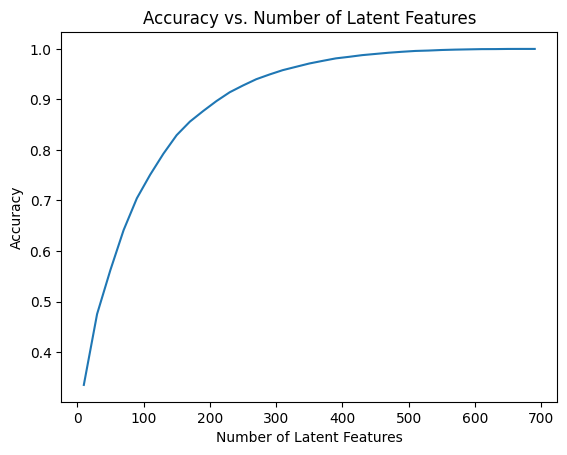

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                     (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    # Create user-item matrix for training data
    user_item_train = create_user_item_matrix(df_train)
    
    # Create user-item matrix for testing data
    user_item_test = create_user_item_matrix(df_test)
    
    # Get test user ids and article ids
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# number of users in test set
len(test_idx)

682

In [ ]:
# number of articles in test set
len(test_arts)

574

In [ ]:
# number of users in train set
len(user_item_train.index)

4487

In [ ]:
# How many users can we make predictions for in the test set?
overlap_user_idx = user_item_train[user_item_train.index.isin(test_idx)]
len(overlap_user_idx) # 

20

In [ ]:
user_item_test.columns.difference(user_item_train.columns) # all articles in test set are in training set too

Index([], dtype='object', name='article_id')

In [ ]:
# Replace the values in the dictionary below
a = 662 # 682 - 20
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
actual_interaction = []
# Iterate over each user-item pair in the test set
for user_id in user_item_test.index:
    for article_id in user_item_test.columns:
        actual_interaction.append((user_id, article_id, user_item_test.loc[user_id, article_id]))

# Convert the actual interaction to a DataFrame
actual_interaction_df_test = pd.DataFrame(actual_interaction, columns=['user_id', 'article_id', 'interaction'])
print(actual_interaction_df_test.interaction.value_counts())
actual_interaction_df_test.head()

interaction
0    387023
1      4445
Name: count, dtype: int64


,user_id,article_id,interaction
0,2917,0.0,0
1,2917,100.0,0
2,2917,1000.0,0
3,2917,1006.0,0
4,2917,1008.0,0


In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [ ]:
def svd_reconstruction(u, s, vt, k):
    """
    Reconstructs a user-item matrix using the top k latent features from Singular Value Decomposition (SVD).

    Parameters:
    u (numpy.ndarray): The left singular matrix obtained from SVD (users x latent features).
    s (numpy.ndarray): The singular values from SVD as a 1D array.
    vt (numpy.ndarray): The transpose of the right singular matrix from SVD (latent features x items).
    k (int): The number of latent features to retain for reconstruction.

    Returns:
    numpy.ndarray: The reconstructed user-item matrix with reduced dimensionality.
    """
    # Select top k latent features
    u_k = u[:, :k]  # Select the first k columns of U
    s_k = np.diag(s[:k])  # Select the first k singular values
    vt_k = vt[:k, :]  # Select the first k rows of Vt
    
    # Reconstruct the user-item matrix
    reconstructed_matrix = np.dot(np.dot(u_k, s_k), vt_k)
    return reconstructed_matrix


In [ ]:
def get_predictions_for_k(k, u, s, vt, user_item_train, user_item_test):
    """
    Predicts values for the test dataset using a reconstructed user-item matrix 
    derived from SVD decomposition with the specified number of latent features.

    Parameters:
    k (int): The number of latent features to retain for reconstruction.
    u (numpy.ndarray): The left singular matrix obtained from SVD (users x latent features).
    s (numpy.ndarray): The singular values from SVD as a 1D array.
    vt (numpy.ndarray): The transpose of the right singular matrix from SVD (latent features x items).
    user_item_train (pandas.DataFrame): The user-item matrix for training data (users as rows, articles as columns).
    user_item_test (pandas.DataFrame): The test dataset with columns `user_id` and `article_id`.

    Returns:
    tuple:
        predictions_df_test (pandas.DataFrame): A DataFrame containing predicted values for `user_id` and `article_id` pairs in the test set.
                                                Columns: ['user_id', 'article_id', 'predicted_value'].
        user_item_pred_df (pandas.DataFrame): The reconstructed user-item matrix (users as rows, articles as columns).
    """
    # Reconstruct the user-item matrix with k latent features
    reconstructed_matrix = svd_reconstruction(u, s, vt, k)
    
    # Convert the reconstructed matrix into a DataFrame
    user_item_pred_df = pd.DataFrame(reconstructed_matrix, index=user_item_train.index, columns=user_item_train.columns)
    predictions = []
    # Iterate over each user-item pair in the test set
    for idx, row in user_item_test.iterrows():
        user_id = row['user_id']
        article_id = row['article_id']
        # Predict the value for each user-article pair
        if user_id in user_item_pred_df.index and article_id in user_item_pred_df.columns:
            predicted_value = user_item_pred_df.loc[user_id, article_id]
        else:
            predicted_value = 0  # If no prediction, assign 0
        predictions.append((user_id, article_id, predicted_value))
    
    # Convert the prediction results to a DataFrame
    predictions_df_test = pd.DataFrame(predictions, columns=['user_id', 'article_id', 'predicted_value'])
    return predictions_df_test, user_item_pred_df


In [ ]:
def evaluate_svd_performance(k_values, u, s, vt, user_item_train, user_item_test):
    """
    Evaluates the performance of SVD-based recommendation by calculating RMSE for 
    different numbers of latent features (k) on both the training and test datasets.

    Parameters:
    k_values (list of int): A list of latent feature counts to evaluate.
    u (numpy.ndarray): The left singular matrix obtained from SVD (users x latent features).
    s (numpy.ndarray): The singular values from SVD as a 1D array.
    vt (numpy.ndarray): The transpose of the right singular matrix from SVD (latent features x items).
    user_item_train (pandas.DataFrame): The user-item matrix for training data (users as rows, articles as columns).
    user_item_test (pandas.DataFrame): The test dataset with columns `user_id`, `article_id`, and `interaction`.

    Returns:
    tuple:
        rmse_values_test (list of float): The RMSE values for the test dataset corresponding to each k value.
        rmse_values_train (list of float): The RMSE values for the training dataset corresponding to each k value.
    """
    rmse_values_test = []
    rmse_values_train = []
    actual_interaction_df_train = user_item_train.to_numpy().flatten()
    
    # Evaluate for each k
    for k in k_values:
        predictions_df_test, user_item_pred_df = get_predictions_for_k(k, u, s, vt, user_item_train, user_item_test)
        
        # Merge predictions with actual values in df_test
        merged_df = pd.merge(predictions_df_test, user_item_test, on=['user_id', 'article_id'], how='left')
        
        # Calculate RMSE for test data
        rmse_test = np.sqrt(mean_squared_error(merged_df['interaction'], merged_df['predicted_value']))
        rmse_values_test.append(rmse_test)
        
        # Calculate RMSE for training data
        rmse_train = np.sqrt(mean_squared_error(actual_interaction_df_train, user_item_pred_df.to_numpy().flatten()))
        rmse_values_train.append(rmse_train)
    
    return rmse_values_test, rmse_values_train


In [ ]:

# Function to perform SVD and return U, S, Vt
def perform_svd_on_train(user_item_train):
    # Perform SVD on the training user-item matrix
    u, s, vt = np.linalg.svd(user_item_train.fillna(0), full_matrices=False)
    return u, s, vt


In [ ]:
# Perform SVD on the training data
u, s, vt = perform_svd_on_train(user_item_train)

# Define the k values to try
# k_values = [1, 5, 10, 20, 50, 100]
k_values = np.arange(10,700+10,20)

# Evaluate SVD performance on different k values
rmse_values_test, rmse_values_train = evaluate_svd_performance(k_values, u, s, vt, user_item_train, actual_interaction_df_test)


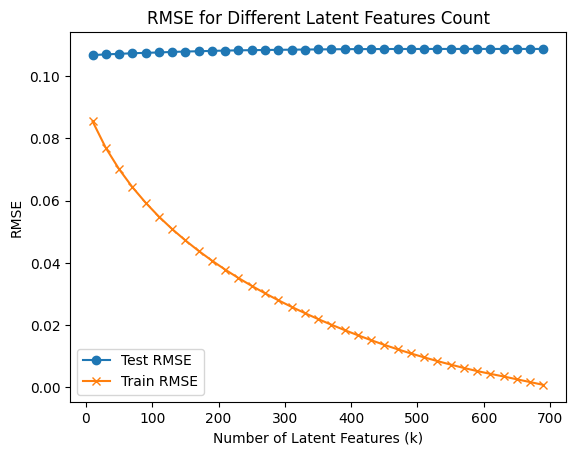

In [ ]:
# Plot RMSE for different k values (optional for better visualization)
plt.plot(k_values, rmse_values_test, marker='o', label='Test RMSE')
plt.plot(k_values, rmse_values_train, marker='x', label='Train RMSE')
plt.title('RMSE for Different Latent Features Count')
plt.xlabel('Number of Latent Features (k)')
plt.ylabel('RMSE')
plt.legend()  # Add legend to differentiate between train and test
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### Observations

##### Training RMSE:
- Decreases steadily as the number of latent features increases.
- Indicates that with more features, the SVD model better reconstructs the training data.

##### Test RMSE:
- Remains constant, with minimal improvement across all values of `k`.
- Suggests that the model is not generalizing well to the test data, which might indicate overfitting on the training data as `k` increases.

#### Recommendations

##### Limit Latent Features (`k`):
- A smaller value of `k` might be more effective for balancing training accuracy and test performance.
- Overfitting can occur with higher `k`, where the model learns noise in the training data.

##### Alternative Approaches:
- Consider regularization techniques during SVD decomposition to prevent overfitting.
- Experiment with hybrid recommendation systems to complement SVD, especially if the dataset is sparse or lacks diversity.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

When using SVD, the **Cold Start Problem** is a common challenge in recommendation systems, arising when there is insufficient information about new users or new items. This issue reduces the ability to personalize recommendations and impacts the performance of algorithms like Collaborative Filtering or Matrix Factorization, which rely on historical data. To address this problem, the following approaches can be applied:

1. **Popularity-Based Recommendations**: Suggest the most popular items or those filtered by category and time for new users.  
2. **Onboarding Questions**: Collect user preferences through a questionnaire during the registration process.  
3. **Profile-Based Recommendations**: Use user information such as age, gender, or location to provide suitable suggestions.  
4. **Content-Based Filtering**: Recommend items based on product features and the user's initial preferences.  
5. **Hybrid Methods**: Combine Content-Based and Collaborative Filtering approaches to improve accuracy with new data.  
6. **Implicit Feedback Utilization**: Leverage user behavior such as clicks or viewing time to infer preferences.  
7. **Deep Learning**: Use techniques like Neural Collaborative Filtering or Factorization Machines to handle limited data effectively.  
8. **A/B Testing**: Experiment with different recommendation strategies to identify the most effective method.  
9. **Contextual Recommendations**: Provide suggestions based on the user's context, such as time, location, or device.  


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1